# Virtual/Material Color/Pigment — Color Quantization Lab
The code in this tutorial is adapted from Douglas Duhaime (["Color Analysis" workshop notebook](https://github.com/YaleDHLab/lab-workshops/tree/master/color-analysis) for the Yale DH Lab); [Adrian Rosebrock](https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/);  [Karan Bhanot](https://github.com/kb22/Color-Identification-using-Machine-Learning); [tarikd](https://github.com/tarikd/python-kmeans-dominant-colors); and [fraxel](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

Before you start....
##File > Save a copy in Drive

# Part 1
# Generating Color Palettes using OpenCV
OpenCV is a huge open-source computer vision library widely used in image processing and machine learning.

## 1. Install/import libraries
*   sklearn = KMeans algorithm
*   matplotlib.pyplot = plotting graphs
*   numpy = work with arrays
*   cv2 = work with image data
*   collections = Counter to count values
*   rgb2lab = convert RGB values
*   deltaE_cie76 = calculate similarity between colors.
*   os = work with file paths

In [ ]:
!wget https://github.com/tracy-st/virtual_material_palettes/raw/main/helpers.py
!wget https://github.com/tarikd/python-kmeans-dominant-colors/raw/master/utils.py
!wget https://github.com/tracy-st/virtual_material_palettes/raw/main/shore.jpg

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

#Display visualizations inside the notebook
%matplotlib inline

In [ ]:
#Functions to create color historgrams and visualizations
import utils
#Utilities to work with images and create plots
import helpers

## 2. Read a sample image



First, let's see what the image looks like as data. We can get the dimensions ("shape") of the image. Then we convert the image object to an "array" (a list of pixels).

In [ ]:
#Sample photograph is Stephen Shore's 'U.S. 10, Post Falls, Idaho, August 25, 1974,' 1974

image_path = 'shore.jpg'
image = cv2.imread(image_path)
print('Image Dimensions :', image.shape)
print(image)

Image Dimensions : (665, 843, 3)
[[[ 48  28  27]
  [ 43  40  25]
  [ 78  69  59]
  ...
  [103 132 206]
  [107 136 210]
  [108 140 213]]

 [[ 59  49  32]
  [ 64  53  39]
  [ 56  57  41]
  ...
  [103 132 206]
  [105 137 210]
  [109 141 214]]

 [[ 60  66  55]
  [ 68  69  60]
  [ 56  65  55]
  ...
  [102 132 203]
  [104 136 207]
  [109 141 212]]

 ...

 [[113 154 203]
  [113 154 203]
  [112 154 201]
  ...
  [109 151 188]
  [103 142 180]
  [116 154 189]]

 [[116 155 207]
  [114 154 203]
  [113 153 201]
  ...
  [117 155 197]
  [110 148 190]
  [112 148 188]]

 [[115 155 204]
  [103 146 189]
  [101 141 190]
  ...
  [115 155 197]
  [118 156 198]
  [118 154 194]]]


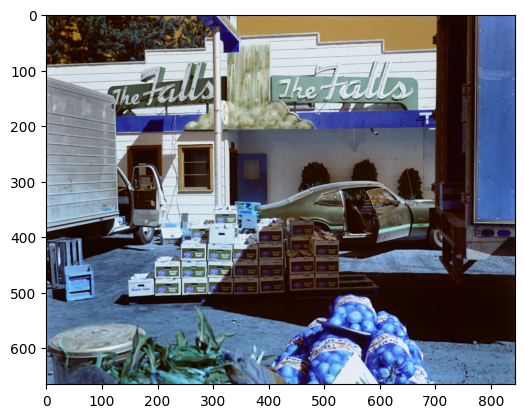

In [ ]:
plt.imshow(image)

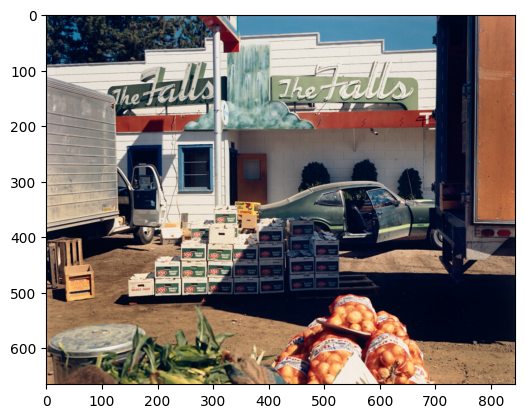

In [ ]:
#Because  OpenCV reads the images in the color order BLUE GREEN RED (BGR), convert to RED GREEN BLUE (RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

We can visualize individual rows using the axis for reference.

(-0.5, 842.5, 0.5, -0.5)

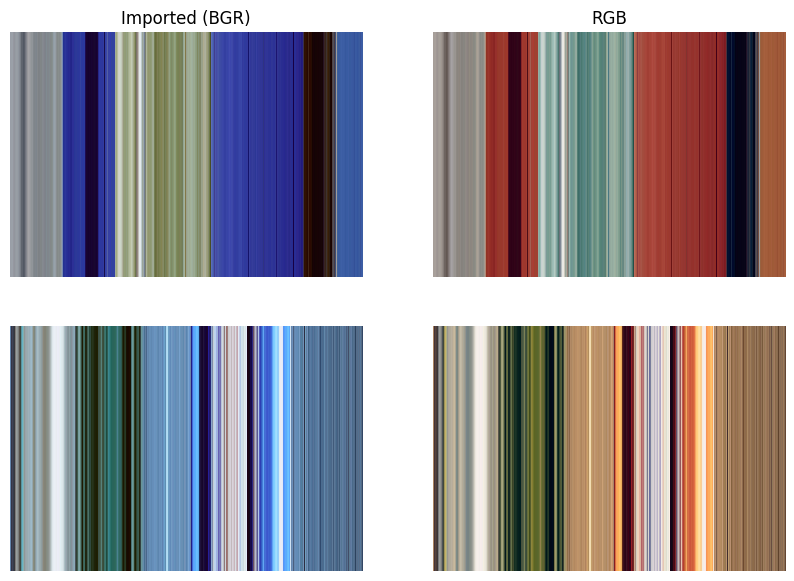

In [ ]:
# convert the image type to an array
arr = np.array(image,dtype=np.uint8)
# Do the same for the RGB image
rgb_arr = np.array(image_rgb,dtype=np.uint8)

# start a new plot
fig = plt.figure(figsize=(10, 7))

# obtain the rows we want to visualize
row = arr[200]
row2 = rgb_arr[200]
row3 = arr[600]
row4 = rgb_arr[600]

# show the row -- interpolation='nearest' and aspect='auto' expand the row vertically to make it easier to see
# try removing those lines and you'll see the plot shows a literal pixel of height for the row, which is hard
# to analyze!
fig.add_subplot(2,2,1)
plt.imshow([row], interpolation='nearest', aspect='auto')
plt.axis('off')
plt.title("Imported (BGR)")
fig.add_subplot(2,2,2)
plt.imshow([row2], interpolation='nearest', aspect='auto')
plt.axis('off')
plt.title("RGB")
fig.add_subplot(2,2,3)
plt.imshow([row3], interpolation='nearest', aspect='auto')
plt.axis('off')
fig.add_subplot(2,2,4)
plt.imshow([row4], interpolation='nearest', aspect='auto')
plt.axis('off')


## Compare the oranges

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(-0.5, 0.5, 0.5, -0.5)

<Figure size 640x480 with 0 Axes>

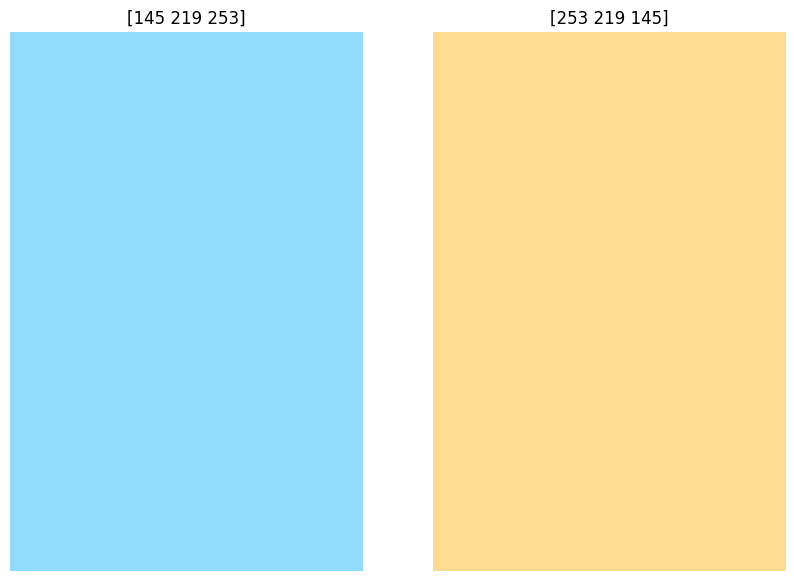

In [ ]:
# access the 600th row, then access the pixel in column number 400 within that row
pixel = arr[550][525]

# Do the same for the RGB image
pixel2 = rgb_arr[550][525]

# create a new plot
plt.figure()
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
# show the pixel. Once again, the interpolation and aspect arguments expand the size of the pixel
# to make the pixel easier to see
plt.imshow([[pixel]], interpolation='nearest', aspect='auto')
plt.title(pixel)
plt.axis('off')
# Do the same for the RGB image
fig.add_subplot(1,2,2)
plt.imshow([[pixel2]], interpolation='nearest', aspect='auto')
plt.title(pixel2)
plt.axis('off')

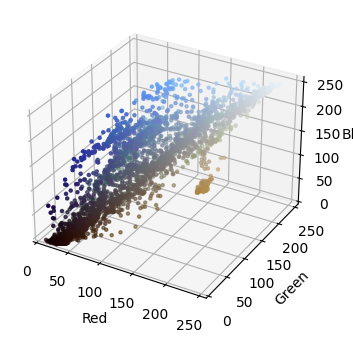

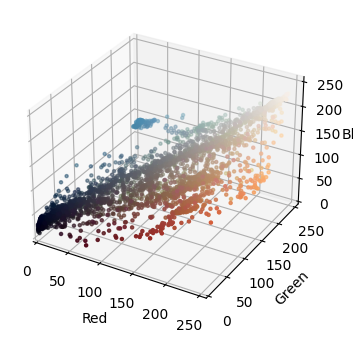

In [ ]:
#visualize as 3d plot2 on the RGB cube
import helpers
helpers.plot_points_3d(arr)
helpers.plot_points_3d(rgb_arr)

## 3. Identify Colors
Define a function that can give us the hex values of the rgb colors we identify.


In [ ]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

Define a function that gets our image.

In [ ]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Define a function that plots a rectangular palette.

In [ ]:
def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)
	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()
	# return the histogram
	return hist

def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

In [ ]:
def list_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	list = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
	# loop over the percentage of each cluster and the color of
	# each cluster
	print(image_path,'\n')
	for (percent, color) in zip(hist, centroids):
		hex = RGB2HEX(color)
		print(color,',',hex,',',percent,end = ',')
		print('\n')

Define a function that gets our palette and plots either the palette or a pie chart.

In [ ]:
def get_colors(image, number_of_colors, show_chart):
  
    #Resize image to make it easier to work with 
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clt = KMeans(n_clusters = number_of_colors)
    labels = clt.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clt.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if show_chart == 'bar':
      # build a histogram of clusters and then create a figure
      # representing the number of pixels labeled to each color
      hist = centroid_histogram(clt)
      bar = plot_colors(hist, clt.cluster_centers_)
      # show our color bart
      plt.figure()
      plt.axis("off")
      plt.imshow(bar)
      plt.show()

    if show_chart == 'pie':
      plt.figure(figsize = (14, 8))
      plt.subplot(221)
      plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

    if show_chart == "list":
      hist = centroid_histogram(clt)
      list = list_colors(hist, clt.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


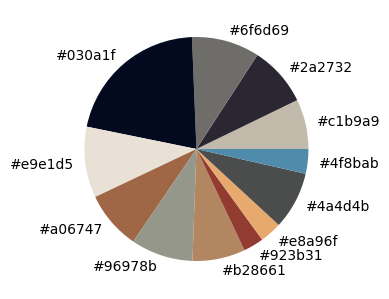

In [ ]:
image_path = 'shore.jpg'

#(image, number of colors, whether to show chart)
#See 12 colors as pie chart
get_colors(get_image(image_path), 12, 'pie')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


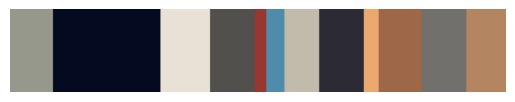

In [ ]:
#See 12 colors as bar chart
get_colors(get_image(image_path), 12, 'bar')

In [ ]:
#See colors as list with hex values and percentages
get_colors(get_image(image_path), 12, 'list')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


shore.jpg 

[150.84264713 151.71460372 139.64666327] , #96978b , 0.0898625,

[41.77544474 38.8773695  50.72528434] , #292632 , 0.0859125,

[233.09550333 225.6060335  213.38038705] , #e9e1d5 , 0.10247916666666666,

[111.26544997 109.60113279 104.86763163] , #6f6d68 , 0.0990375,

[145.78026018  59.63928167  49.61241516] , #913b31 , 0.029241666666666666,

[ 79.60717636 139.37429644 171.130394  ] , #4f8bab , 0.035520833333333335,

[232.42827443 169.22284304 111.62162162] , #e8a96f , 0.032,

[178.39808036 134.15237785  97.66124397] , #b28661 , 0.0768375,

[ 3.75560432 10.44842447 30.97574428] , #030a1e , 0.21094166666666667,

[74.12067404 76.88455734 75.3360664 ] , #4a4c4b , 0.08292083333333333,

[160.00816183 103.3639277   71.270342  ] , #a06747 , 0.08337083333333334,

[193.78241975 186.03331788 169.96355313] , #c1baa9 , 0.071875,



# Part 2
# Generating Color Palettes using Machine Learning

##  1. Install required libraries

In [ ]:
!wget https://github.com/YaleDHLab/lab-workshops/raw/master/color-analysis/requirements.txt
!pip install -r requirements.txt

--2023-06-11 19:07:13--  https://github.com/YaleDHLab/lab-workshops/raw/master/color-analysis/requirements.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/color-analysis/requirements.txt [following]
--2023-06-11 19:07:13--  https://raw.githubusercontent.com/YaleDHLab/lab-workshops/master/color-analysis/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     154  --.-KB/s    in 0s      

2023-06-11 19:07:13 (7.80 MB/s) - ‘requirements.txt’ saved [154/154]


In [ ]:
#webcolors is a module for working with HTML/CSS color definitions
!pip install webcolors==1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for webcolors: filename=webcolors-1.3-py3-none-any.whl size=13015 sha256=6be46ec08c7cf26fd99088927e6ecdbafbd09f88fc53f34cbb4baa6af05e49cd
  Stored in directory: /root/.cache/pip/wheels/a9/87/d7/7d80a7bc0e15270ab6de7f5451ff4555cea69b2f448efacf77
Successfully built webcolors
  Attempting uninstall: webcolors
    Found existing installation: webcolors 1.13
    Uninstalling webcolors-1.13:
      Successfully uninstalled webcolors-1.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
music21 8.1.0 requires webcolors>=1.5, but you have webcolors 1.3 which is incompatible.


In [ ]:
import webcolors
import keras
import os
import glob
import utils
import helpers
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

%matplotlib inline

## 2. Load our file

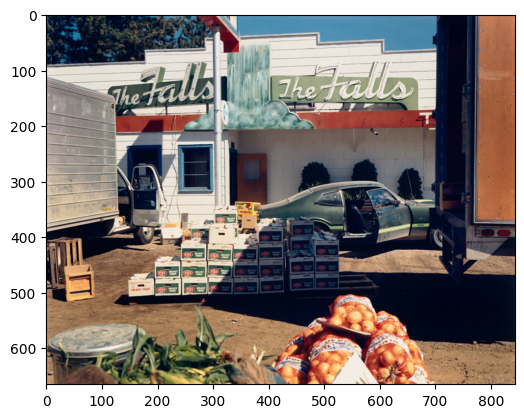

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

# get a sample file
sample_file = 'shore.jpg'

# read in the image
im = load_img(sample_file)

# convert the image type to an array
arr = img_to_array(im).astype('uint8')

# create a new plot
plt.figure()

# plot the image
plt.imshow(arr)

## 3. Generate a palette

In [ ]:
import colorthief
from colorthief import ColorThief

# identify the 7 colors that best represent the color palette in this image
sample = ColorThief(sample_file).get_palette(color_count=12)

# create a new plot
plt.figure()

# show the palette
plt.imshow([sample])

ModuleNotFoundError: ignored

In [ ]:
# sort the colors in this palette along "roygbiv" spectrum:
sample.sort()

# create a new figure
plt.figure()

# show the extracted colors
plt.imshow([sample])

# Part 3
# More Art

In [ ]:
!wget https://lab-data-collections.s3.amazonaws.com/famous-paintings.tar.gz
!tar -zxf famous-paintings.tar.gz 

--2021-08-12 23:32:34--  https://lab-data-collections.s3.amazonaws.com/famous-paintings.tar.gz
Resolving lab-data-collections.s3.amazonaws.com (lab-data-collections.s3.amazonaws.com)... 52.217.8.196
Connecting to lab-data-collections.s3.amazonaws.com (lab-data-collections.s3.amazonaws.com)|52.217.8.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54668468 (52M) [application/x-tar]
Saving to: ‘famous-paintings.tar.gz’

famous-paintings.ta 100%[===================>]  52.14M  37.0MB/s    in 1.4s    

2021-08-12 23:32:36 (37.0 MB/s) - ‘famous-paintings.tar.gz’ saved [54668468/54668468]



In [ ]:
# populate a list of image files
files = sorted(glob.glob('/content/data/Giotto_di_Bondone-*.jpg'))

# print the list of files we'll analyze
files

['/content/data/Giotto_di_Bondone-0.jpg',
 '/content/data/Giotto_di_Bondone-1.jpg',
 '/content/data/Giotto_di_Bondone-10.jpg',
 '/content/data/Giotto_di_Bondone-11.jpg',
 '/content/data/Giotto_di_Bondone-12.jpg',
 '/content/data/Giotto_di_Bondone-13.jpg',
 '/content/data/Giotto_di_Bondone-14.jpg',
 '/content/data/Giotto_di_Bondone-15.jpg',
 '/content/data/Giotto_di_Bondone-16.jpg',
 '/content/data/Giotto_di_Bondone-17.jpg',
 '/content/data/Giotto_di_Bondone-18.jpg',
 '/content/data/Giotto_di_Bondone-19.jpg',
 '/content/data/Giotto_di_Bondone-2.jpg',
 '/content/data/Giotto_di_Bondone-3.jpg',
 '/content/data/Giotto_di_Bondone-4.jpg',
 '/content/data/Giotto_di_Bondone-5.jpg',
 '/content/data/Giotto_di_Bondone-6.jpg',
 '/content/data/Giotto_di_Bondone-7.jpg',
 '/content/data/Giotto_di_Bondone-8.jpg',
 '/content/data/Giotto_di_Bondone-9.jpg']

In [ ]:
giotto = '/content/data/Giotto_di_Bondone-0.jpg'

get_colors(get_image(giotto), 12, 'pie')
get_colors(get_image(giotto), 12, 'bar')
get_colors(get_image('/content/data/Giotto_di_Bondone-0.jpg'), 12, 'list')

In [ ]:
palette = ColorThief(file).get_palette(color_count=7)

When seen in isolation, these sorted colors are not always perfectly intuitive, but when seen in the aggregate we can see that color sorting helps make some patterns easier to see. Let's see this in practice by analyzing the colors in each painting by Giotto.

In [ ]:
# create a list that will hold the colors for each painting
all_colors = []

# loop over each file
for file in files:
  
  # identify the 7 colors that best represent the color palette in this image
  palette = ColorThief(file).get_palette(color_count=7)
  
  # sort the palette as we did above
  palette.sort()

  #for color in palette:
    #print(get_colour_name(requested_colour))

  # add this list of colors to the all_colors list
  all_colors.append(palette)

# create a new plot
plt.figure()

# plot all of the colors
plt.imshow(all_colors)


We can see pretty quickly that Giotto images in our dataset tend to have either red or blue.

In [ ]:
# loop over each file and print hex values
for file in files:
  # identify the 7 colors that best represent the color palette in this image
  palette = ColorThief(file).get_palette(color_count=7)
  
  # sort the palette as we did above
  palette.sort()
  #get filename
  head, tail = os.path.split(file)
  print("{{'filename': '{}',".format(tail))

  for num, item in enumerate(palette):
      rgb_code = color(rgb=item)
      hex = rgb_code.hex
      name = get_colour_name(item)

      print("'rgb{}': '{}',".format(num, item))
      print("'hex{}': '{}',".format(num, hex))
      print("'name{}': '{}',".format(num, name))

  print("},")

     # with open(json_file_name, 'a') as f:
         # f.write('[{"filename" : "' + tail + '",' + '\n, "colors":\n' + item + '\n' + hex + '\n' + name + '\n')
      #print(name)
      #store_json_colors(name)


{'filename': 'Giotto_di_Bondone-0.jpg',


NameError: ignored

In [ ]:
data_file_name = "color_data.js"

with open(data_file_name, "a") as f:

# loop over each file and print hex values
#sorted_all = sorted(all_files)
  f.write("var colorData = [\n")
  
  for file in files:
    # identify the 7 colors that best represent the color palette in this image
    palette = ColorThief(file).get_palette(color_count=7)
    
    # sort the palette as we did above
    palette.sort()
    #get filename
    head, tail = os.path.split(file)
    #print("{{'filename': '{}',".format(tail))
    f.write("{{'filename': '{}',\n".format(tail))

    for num, item in enumerate(palette):
        rgb_code = color(rgb=item)
        hex = rgb_code.hex
        name = get_colour_name(item)

        #print("'rgb{}': '{}',".format(num, item))
        #print("'hex{}': '{}',".format(num, hex))
        #print("'name{}': '{}',".format(num, name))

        f.write("'rgb{}': '{}',\n".format(num, item))
        f.write("'hex{}': '{}',\n".format(num, hex))
        f.write("'name{}': '{}',\n".format(num, name))

    f.write("},\n")
  
  f.write("]") 

Let's now analyze the paintings by all of the painters in our dataset to compare.

In [ ]:
# initialize an empty list in which we'll store the color data for each artist
all_artist_colors = defaultdict(list)

# identify the list of files to process
all_files = sorted(glob.glob('data/*.jpg'))

# loop over each file
for file in sorted(all_files):
  
  # identify the artist's name
  artist = file.split('/')[1].split('-')[0]
  
  # get the representative colors from this image
  palette = ColorThief(file).get_palette(color_count=6)
  
  # sort the palette as we did above
  palette.sort()
  
  # add this list of colors to the artist's colors
  all_artist_colors[artist].append(palette)
  
  # print a progress update
  print(' * processed', file)

In [ ]:
# initialize a plot that will contain 5 rows and 7 columns
fig, ax = plt.subplots(5, 7, figsize=(10,10))

# create a list of lists where sublists contain artists and their colorswatches
arist_color_pairs = list(all_artist_colors.items())

# create a counter variable that will keep track of which cell we are populating within the chart
index = 0
  
# loop over each row in the chart
for row in ax:
  
  # loop over each column in this row
  for col in row:
    
    # get the appropriate artist and color pair
    artist, colors = arist_color_pairs[index]
    
    # add this artist's colors to the current cell in the chart
    col.imshow(colors, interpolation='nearest', aspect='auto')
    
    # add this artist's name as the title in the current cell in the chart
    col.set_title(artist, fontsize=7)
    
    # remove the axes from this cell in the chart
    col.axis('off')
    
    # increase the index
    index += 1

Now, we will write our color data to a file that we can use for further exploration.

In [ ]:
data_file_name = "all_artists.js"

with open(data_file_name, "a") as f:

# loop over each file and print hex values
#sorted_all = sorted(all_files)
  f.write("var colorData = [\n")
  
  for file in sorted(all_files):
    # identify the 7 colors that best represent the color palette in this image
    palette = ColorThief(file).get_palette(color_count=7)
    
    # sort the palette as we did above
    palette.sort()
    #get filename
    head, tail = os.path.split(file)
    #print("{{'filename': '{}',".format(tail))
    f.write("{{'filename': '{}',\n".format(tail))

    for num, item in enumerate(palette):
        rgb_code = color(rgb=item)
        hex = rgb_code.hex
        name = get_colour_name(item)

        #print("'rgb{}': '{}',".format(num, item))
        #print("'hex{}': '{}',".format(num, hex))
        #print("'name{}': '{}',".format(num, name))

        f.write("'rgb{}': '{}',\n".format(num, item))
        f.write("'hex{}': '{}',\n".format(num, hex))
        f.write("'name{}': '{}',\n".format(num, name))

    f.write("},\n")
  
  f.write("]") 

# Experiment: Daguerreotypes

In [ ]:
from google.colab import files

In [ ]:
!unzip /content/drive/MyDrive/Virtual_Material/handcolorcrop.zip -d /content/handcolorcrop

In [ ]:
def hexify(rgb):
    return "#{0:02x}{1:02x}{2:02x}".format(*rgb)
    
def rgb_to_hex(palette):
    hex_colors = list(map(hexify, palette))
    print(hex_colors)

In [ ]:
import pickle

# identify the list of files to process
hand_color = sorted(glob.glob('handcolorcrop/*.jpg'))

# create a list that will hold the colors for each painting
all_photos = []

# loop over each file
for file in sorted(hand_color):
  
  # identify the 7 colors that best represent the color palette in this image
  palette = ColorThief(file).get_palette(color_count=7)
  
  # sort the palette as we did above
  palette.sort()

  hex = rgb_to_hex(palette)

  #for color in palette:
    #print(get_colour_name(requested_colour))

  # add this list of colors to the all_colors list
  all_photos.append(hex)

with open("photo_colors.txt", "wb") as f:
    pickle.dump(all_photos, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
print(all_photos)

In [ ]:
print(palette)

def rgb_to_hex(palette):
    hex_colors = list(map(hexify, palette))
    print(hex_colors)

rgb_to_hex(palette)

In [ ]:
def draw_row_with_links(colors):
    html = ""
    #url = link_and_colors[0]
    for count, color in enumerate(colors):
        square = '<rect x="{0}" y="{1}" width="30" height="30" fill="{2}" />'.format(((count * 30) + 30), 0, color)
        html += square
    full_html = '<svg height="30" width="210">{0}</svg>'.format(html)    
    return full_html

In [ ]:
from IPython.display import display, HTML

single_item = (photo_hex[0])
print(single_item)
html = draw_row_with_links(single_item)
print(html)

display(HTML(html))

In [ ]:
linkable_baseball_page_html = ""

for image in photo_hex:
    line = draw_row_with_links(image)
    linkable_baseball_page_html += line
    
display(HTML(linkable_baseball_page_html))

In [ ]:
data_file_name = "photo_data.js"

with open(data_file_name, "a") as f:

# loop over each file and print hex values
#sorted_all = sorted(all_files)
  f.write("var colorData = [\n")
  
  for file in sorted(hand_color):
    # identify the 7 colors that best represent the color palette in this image
    palette = ColorThief(file).get_palette(color_count=7)
    
    # sort the palette as we did above
    palette.sort()
    #get filename
    head, tail = os.path.split(file)
    #print("{{'filename': '{}',".format(tail))
    f.write("{{'filename': '{}',\n".format(tail))

    for num, item in enumerate(palette):
        rgb_code = color(rgb=item)
        hex = rgb_code.hex
        name = get_colour_name(item)

        #print("'rgb{}': '{}',".format(num, item))
        #print("'hex{}': '{}',".format(num, hex))
        #print("'name{}': '{}',".format(num, name))

        f.write("'rgb{}': '{}',\n".format(num, item))
        f.write("'hex{}': '{}',\n".format(num, hex))
        f.write("'name{}': '{}',\n".format(num, name))

    f.write("},\n")
  
  f.write("]") 